## 1.1 Preliminiary
##### Mount drive, import images, train/valid/test-set split, save data locally

In [ ]:
import os

# Initialization
lowest_level = 2
highest_level = 4

save_dir_name = 'Lev_345_split_933_stride_150_pmin_50'
dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
saving_dir = os.path.join(dir,save_dir_name)

print("saving directory: ", saving_dir)

saving directory:  /content/drive/MyDrive/Applied_Deep_Learning_Project/save_data_234/


In [ ]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.3.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [ ]:
!apt-get install openslide-tools  # Openslide , Install the OpenSlide C library and Python bindings
!apt-get install python3-openslide # After installing these libraries, use `Runtime -> restart and run all` on the menu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-2ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
# from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_open_slide(tissue_path, mask_path, return_tissue):
# Function that opens an image based on path
# Note: return_tissue = boolean value, 
#      Ture -> reads tissue img, False -> reads masks image

  slide = open_slide(tissue_path)
  print ("Read WSI from %s with width: %d, height: %d" % (tissue_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))
  mask = open_slide(mask_path)
  print ("Read tumor mask from %s" % (mask_path))

  print("Slide includes %d levels", min(len(slide.level_dimensions),len(mask.level_dimensions)))
  for i in range(min(len(slide.level_dimensions),len(mask.level_dimensions))):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                              slide.level_dimensions[i], 
                                                              slide.level_downsamples[i]))

      assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  if (return_tissue):
    return slide
  else:
    return mask

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0. 
# There is an example below of working with coordinates with respect to a higher zoom level.

# Read a region from the slide, Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# Gets difference of two lists using set operator
def difference(L1, L2):
    return (list(list(set(L1)-set(L2)) + list(set(L2)-set(L1))))

# detect and remove if number of images and masks are different
def balance_imgs(image_path_l, mask_path_l):
  img_num_l = [re.findall(r'\d+', string)[0] for string in image_path_l ] # list of image numbers
  mask_num_l = [re.findall(r'\d+', string)[0] for string in mask_path_l ] # list of mask's image numbers

  img_len = len(img_num_l)
  mask_len = len(mask_num_l)

  # delete images that are not same in number of lengths automatically
  if img_len != mask_len:
    print("Tissue image length: {}".format(len(image_path_l)))
    print("Mask image length: {}".format(len(mask_path_l)))

    diff_img_num = difference(img_num_l,mask_num_l)[0]

    if img_len > mask_len: # i.e. need to find extra image and delete
      print("Removed image number {} since there is no corresponding biopsy image".format(diff_img_num))
      del image_path_l[img_num_l.index(diff_img_num)]

    else: 
      print("Removed mask number {} since there is no corresponding  image".format(diff_img_num))
      del mask_path_l[mask_num_l.index(diff_img_num)]

  return image_path_l, mask_path_l

In [ ]:
# Note: since importing slides from Professor's Google API does not work sometimes,
# we downloaded the images to 'locally' in Google Drive
directory = '/content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/'

biopsy_path_list = []
mask_path_list = []

for file in os.scandir(directory):
  
  if ("tif" in file.name):
    if ("mask" in file.name):
      mask_path_list.append(file.path) 
  
    else:
      biopsy_path_list.append(file.path)

# # Automatically removes images that are not both exists in image and masks
biopsy_path_list,mask_path_list = balance_imgs(biopsy_path_list,mask_path_list)

biopsy_path_list.sort()
mask_path_list.sort()

Tissue image length: 22
Mask image length: 21
Removed image number 038 since there is no corresponding biopsy image


####  Since the number of biopsy and mask images are different, image number 38 got deleted from the initially given sample. Also, we removed some other biopsy/mask images that do not have cancer percentage high enough

## Hyukjoon -> write function to show image's percentage of cancer piexel (i.e. why removed more examples)

In [ ]:
def extract_img_numbers(string_list):
  int_list = []
  for str in string_list:
    img_num = re.findall(r'\d+', str)[0]
    int_list.append(int(img_num))

  return sorted(int_list)

### Perhaps show initial analysis? (i.e. pictures of biopsy, mask image?)
#### i.e. what is training biopsy image looks like, valid, test?

In [ ]:
# %pprint
# biopsy_img_num_l = extract_img_numbers(biopsy_path_list)
# display(biopsy_img_num_l)

In [ ]:
train_index = [2,4,5,6,7,12,16,18,20]
test_index = [11,13,17]
valid_index = [0,15,19]

biopsy_train = [biopsy_path_list[i] for i in train_index]
biopsy_test = [biopsy_path_list[i] for i in test_index]
biopsy_valid = [biopsy_path_list[i] for i in valid_index]
mask_train = [mask_path_list[i] for i in train_index]
mask_test = [mask_path_list[i] for i in test_index]
mask_valid = [mask_path_list[i] for i in valid_index]

In [ ]:
print("Total num of samples used: ", len(biopsy_train) + len(biopsy_valid) +len(biopsy_test))
print("Each train/val/test set length: \n biopsy -> train: {} val: {} test: {} \n Mask -> train: {} val: {} test: {}".format(
     len(biopsy_train), len(biopsy_valid), len(biopsy_test), 
     len(mask_train), len(mask_valid), len(mask_test)  ))

print()
print("Biopsy img number in train set: {}".format(extract_img_numbers(biopsy_train)))
print("Biopsy img number in valid set: {}".format(extract_img_numbers(biopsy_valid)))
print("Biopsy img number in test set: {}".format(extract_img_numbers(biopsy_test)))

Total num of samples used:  15
Each train/val/test set length: 
 biopsy -> train: 9 val: 3 test: 3 
 Mask -> train: 9 val: 3 test: 3

Biopsy img number in train set: [5, 16, 19, 23, 31, 75, 91, 96, 110]
Biopsy img number in valid set: [1, 84, 101]
Biopsy img number in test set: [64, 78, 94]


In [ ]:
#Getting the slides using each of the train/test/valid directory
biopsy_slides_train = [get_open_slide(x,y,True) for x,y in zip(biopsy_train, mask_train)] # Ture -> reads tumor img, False -> reads masks image
mask_slides_train = [get_open_slide(x,y,False) for x,y in zip(biopsy_train, mask_train)]

biopsy_slides_valid = [get_open_slide(x,y,True) for x,y in zip(biopsy_valid, mask_valid)]
mask_slides_valid = [get_open_slide(x,y,False) for x,y in zip(biopsy_valid, mask_valid)]

#biopsy_slides_test = [get_open_slide(x,y,True) for x,y in zip(biopsy_test, mask_test)]
#mask_slides_test = [get_open_slide(x,y,False) for x,y in zip(biopsy_test, mask_test)]

Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_005.tif with width: 97792, height: 219648
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_005_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (97792, 219648) downsample factor 1
Level 1, dimensions: (48896, 109824) downsample factor 2
Level 2, dimensions: (24448, 54912) downsample factor 4
Level 3, dimensions: (12224, 27456) downsample factor 8
Level 4, dimensions: (6112, 13728) downsample factor 16
Level 5, dimensions: (3056, 6864) downsample factor 32
Level 6, dimensions: (1528, 3432) downsample factor 64
Level 7, dimensions: (764, 1716) downsample factor 128
Level 8, dimensions: (382, 858) downsample factor 256
Read WSI from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_016.tif with width: 97792, height: 221184
Read tumor mask from /content/drive/MyDrive/Applied_Deep_Learning_Project/slides_local/tumor_016_mask.tif
Slid

#### Use filter to facilitate training proces
##### i.e. regions where tissue is -> where grey value is lower than 0.8

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return len(indices[0]) # i.e. return length of number of pixels that have lower intensity

# A modified version of the finding tissue pixel 
# Returns True if area of present biopsy image is above the threshold, min_percentage,
def pass_tissue_percentage(slide_image, tissue_p_min, w, h):
  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = tissue_pixels/ float(w*h) * 100

  if percent_tissue > tissue_p_min:
    # print("----------------",("%.2f" % round(percent_tissue, 2)))
    return True
  else:
    return False

# test whether a patch has cancer or not
def has_cancer(patch):
  return sum(sum(chain.from_iterable(patch))) != 0

In [ ]:
def downsample_factor(slide, level):

  return (int(slide.level_downsamples[level]))


# Transforms a coordinate associated with a current zoom level
def transform_coord(slide, input_coord, base_level, current_level, patch_size):

  base_lev_factor = downsample_factor(slide,base_level)
  current_lev_factor = downsample_factor(slide,current_level)

  new_coord = input_coord * base_lev_factor - int(patch_size/2) * current_lev_factor
  return new_coord


# Reads slide according to the transformed coordinate
def read_zoom_slide(slide, x_input, y_input, base_lev, current_lev, patch_size):

  slide = read_slide(slide, 
                     transform_coord(slide, x_input, base_lev, current_lev, patch_size ),
                     transform_coord(slide, y_input, base_lev, current_lev, patch_size ),
                     level = current_lev, width = patch_size, height = patch_size)
  return slide

# Computes a relative magnification difference between two zoom levels
def compute_relative_mag(base_lev, current_lev):

  result = 2 ** (base_lev - current_lev)  # i.e. base_lev = 7, current_lev =5, then current level is zoomed 4 times more
  return result


# Computes Rectangle with appropriate coordinates in the current zoom level,
# with relative to the base level (most zoomed out level) 
def compute_rectangle(relative_magnification, patch_size = 299, center_size = 128):

  return Rectangle((int(patch_size / 2) - int(center_size / (2 ** (relative_magnification + 1))),
                  int(patch_size / 2) - int(center_size / (2 ** (relative_magnification + 1)))),
                  center_size / (2**relative_magnification),
                  center_size  / (2**relative_magnification),
                  facecolor='none', edgecolor='red')

### Testing whether making center patch coordinates works for different zoom levels

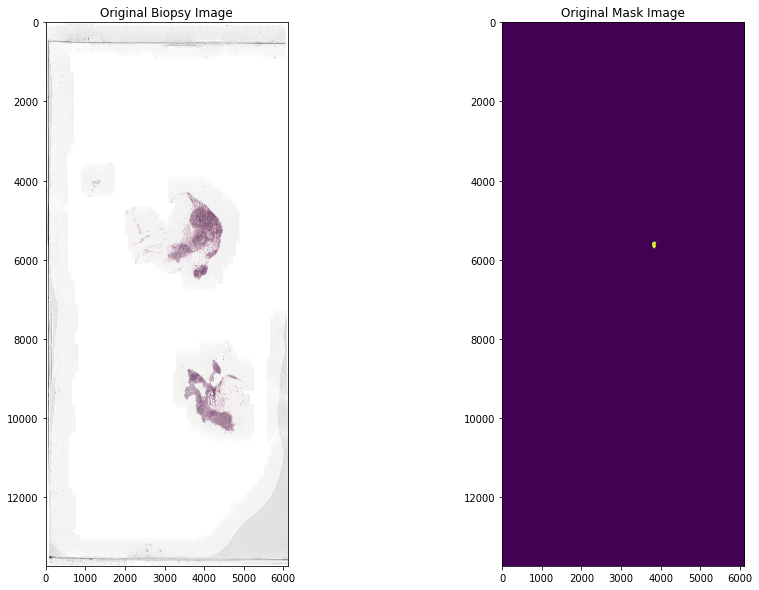

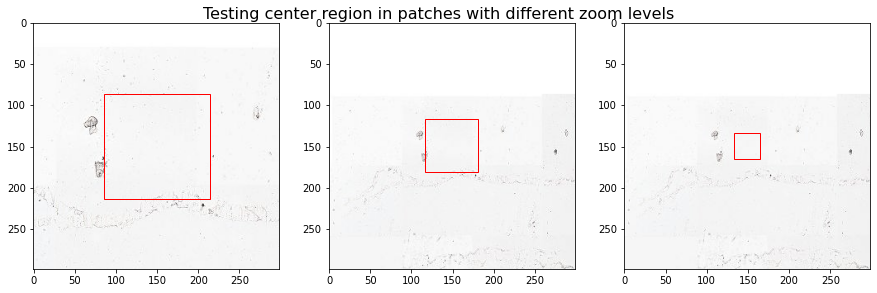

In [ ]:
index = 2
base_level = 4
biopsy_slide = biopsy_slides_train[index]
mask_slide = mask_slides_train[index]

downsample_f = downsample_factor(biopsy_slide, base_level)

biopsy_img = read_slide(biopsy_slide, x=0, y=0, level=base_level, 
                        width=biopsy_slide.level_dimensions[base_level][0], height=biopsy_slide.level_dimensions[base_level][1])
mask_img = read_slide(mask_slide, x=0, y=0, level = base_level, 
                         width=mask_slide.level_dimensions[base_level][0], height=mask_slide.level_dimensions[base_level][1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
axes[0].imshow(biopsy_img)
axes[0].set_title("Original Biopsy Image")
axes[1].imshow(mask_img[:,:,0])
axes[1].set_title("Original Mask Image")

p_size =299 # patch size
x = 150 # starting patch position
y =150

lev_7 = base_level
lev_6 =4
lev_5 = 3

slide_image_7 = read_zoom_slide(biopsy_slide, x, y, base_level, lev_7, p_size)
slide_image_6 = read_zoom_slide(biopsy_slide, x, y, base_level, lev_6, p_size)
slide_image_5 = read_zoom_slide(biopsy_slide, x, y, base_level, lev_5, p_size)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
fig.suptitle("Testing center region in patches with different zoom levels", fontsize=16)
fig.subplots_adjust(top=1.45)

axes[0].imshow(slide_image_5)
axes[0].add_patch(Rectangle((150-128//2,150-128//2),128,128,facecolor='none',edgecolor='red'))
axes[1].imshow(slide_image_6)
axes[1].add_patch(compute_rectangle(1))
axes[2].imshow(slide_image_7)
axes[2].add_patch(compute_rectangle(2))

In [ ]:
def print_patches(patch_list, base_l, current_l):
  number_patches = len(patch_list)
  fig, axes = plt.subplots(nrows=1, ncols=number_patches, figsize=(15,10))
  for idx, slide in enumerate(patch_list):
    axes[idx].imshow(slide)
    axes[idx].add_patch(compute_rectangle(idx))

def print_masks(patch_list, base_l, current_l):
  number_patches = len(patch_list)
  fig, axes = plt.subplots(nrows=1, ncols=number_patches, figsize=(15,10))
  for idx, slide in enumerate(patch_list):
    axes[idx].imshow(slide[:,:,0])
    axes[idx].add_patch(compute_rectangle(idx))

In [ ]:
def create_patches(biopsy_slide, mask_slide, lowest_level = 5, highest_level = 7, apply_filter = False):

  p_size = 299  # patch size
  stride = 299  # need to chnage (here, for zoom level 5, which is lowest level)

  tissue_p_min = 40  # i.e. treshold of minimum percentage of tissue converaged in percentage
                # i.e. if patch has more than 10% of tissue pixels, then take it
  biopsy_list = []
  label_list = []

  # Starting center coordinates
  x = int(p_size/2) # i.e. 150
  y = int(p_size/2)

  biopsy_w_high = biopsy_slide.level_dimensions[highest_level][0]
  biopsy_h_high = biopsy_slide.level_dimensions[highest_level][1]

  biopsy_w_low = biopsy_slide.level_dimensions[lowest_level][0]
  biopsy_h_low = biopsy_slide.level_dimensions[lowest_level][1]

  # print(biopsy_w_high, biopsy_w_high * slide.level_downsamples[base])

  biopsy_list_batch = []
  
  run = True

  global patch_counter
  patch_counter=0
  patch_x_counter=0
  patch_y_counter=0

  print("lowest dim shape:",biopsy_w_low, " ", biopsy_h_low )

  # print("Applying filtering? : -> ", apply_filter)

  while(run):
    # print("Coordinate: " + str(x) + " " + str(y))
     

    if (y < biopsy_h_high  - 299//2):  # i.e. slide based on highest level since it is most zoomed out version
      if (x < biopsy_w_high - 299//2):
        biopsy_list_batch = []

        slide_image_temp = read_zoom_slide(biopsy_slide, x, y, highest_level, lowest_level, p_size)

        if apply_filter: # i.e. apply filtering only for training set, s
          # print("Applying tissue filtering")
          if pass_tissue_percentage(slide_image_temp, tissue_p_min, p_size, p_size): # i.e. only using if lowest label passes the tissue test

            for current_level in range(lowest_level, highest_level + 1):
              slide_image = read_zoom_slide(biopsy_slide, x, y, highest_level, current_level, p_size)
              mask_image = read_zoom_slide(mask_slide, x, y, highest_level, current_level, p_size)

              biopsy_list_batch.append(slide_image)

              mask_image = read_zoom_slide(mask_slide, x, y, highest_level, current_level, p_size)
              if (current_level == lowest_level): # Do it with only the first image
                # print("pass_cord: " + str(x) + " " + str(y) + " " + str(has_cancer(mask_image)), end=', ', flush=True)
                label_list.append(has_cancer(mask_image))
                                        
              else:
                continue;

        else:  # do not apply tissue filtering for valid, test set
          # print("Not applying filtering for training set")
          for current_level in range(lowest_level, highest_level + 1):
            slide_image = read_zoom_slide(biopsy_slide, x, y, highest_level, current_level, p_size)
            mask_image = read_zoom_slide(mask_slide, x, y, highest_level, current_level, p_size)

            biopsy_list_batch.append(slide_image)

            mask_image = read_zoom_slide(mask_slide, x, y, highest_level, current_level, p_size)
            if (current_level == lowest_level): # Do it with only the first image
              # print("pass_cord: " + str(x) + " " + str(y) + " " + str(has_cancer(mask_image)), end=', ', flush=True)
              label_list.append(has_cancer(mask_image))
                                      
            else:
              continue;
        # print_patches(biopsy_list_batch, highest_level, current_level)
        # print_masks(mask_list_batch, highest_level, current_level)

        if len(biopsy_list_batch) !=0:
          biopsy_list.append(biopsy_list_batch)

        patch_counter += 1
        patch_x_counter += 1
        x = x + int(stride / biopsy_slide.level_downsamples[highest_level] *  biopsy_slide.level_downsamples[lowest_level])
        
      else: # i.e. progress toward next 'row' below
        x = int(p_size/2) 
        y = y + int(stride / biopsy_slide.level_downsamples[highest_level] *  biopsy_slide.level_downsamples[lowest_level])
      
        patch_y_counter += 1
        if (y < biopsy_h_high  - 299//2):
          patch_x_counter = 0

    else: 
      run = False  
  

  assert len(biopsy_list) == len(label_list)
  print("tissue filtering percentage used: ", "{:.2f}".format(len(biopsy_list)/patch_counter*100), "%")

  print(np.array(label_list).shape)

  if apply_filter: # i.e. for training set
    return biopsy_list, label_list
  
  else: # i.e. for test set, also returning patches_num
    patches_num = [patch_counter, patch_x_counter, patch_y_counter]
    print("patches num: ", patches_num)
    
    return biopsy_list, label_list, patches_num 


### Flatten and put train and validation set into Numpy array formats

In [ ]:
# flatten each biopsy patch into its zoom level
def flatten_biopsy_zoom(biopsy_patch):
  zoom1 = []
  zoom2 = []
  zoom3 = []

  for biopsy in biopsy_patch:
    # print(np.array(biopsy).shape)
    for patch_img in biopsy:
      zoom1.append(patch_img[0])
      zoom2.append(patch_img[1])
      zoom3.append(patch_img[2])

  assert np.array(zoom1).shape == np.array(zoom2).shape == np.array(zoom3).shape
  return  np.array(zoom1),  np.array(zoom2),  np.array(zoom3)

# flatten label
def flatten_label(label_list):
  label = []
  for image in label_list:
    for i in image:
      label.append(i*1)
  print(np.array(label).shape)
  return np.array(label)

#### Save Train and Validation set as an Numpy format

In [ ]:
files_list = os.listdir(saving_dir)

if len(files_list) != 0:
  for file in files_list: #i.e. delete old files each time
    os.remove(os.path.join(saving_dir,file))

In [ ]:
result_train =[create_patches(slide, mask, lowest_level = lowest_level, highest_level = highest_level, apply_filter = True) for slide,mask in zip(biopsy_slides_train, mask_slides_train)]
biopsy_patch_train = [item[0] for item in result_train]
label_train =[item[1] for item in result_train]

zoom1_train, zoom2_train, zoom3_train = flatten_biopsy_zoom(biopsy_patch_train)
label_train = flatten_label(label_train)

# saving files in Numpy formats
np.save(os.path.join(saving_dir,'zoom1_train.npy'),zoom1_train)
np.save(os.path.join(saving_dir,'zoom2_train.npy'),zoom2_train)
np.save(os.path.join(saving_dir,'zoom3_train.npy'),zoom3_train)
np.save(os.path.join(saving_dir,'label_train.npy'),label_train)

lowest dim shape: 24448   54912
tissue filtering percentage used:  4.08 %
(586,)
lowest dim shape: 24448   55296
tissue filtering percentage used:  5.02 %
(726,)
lowest dim shape: 24448   54912
tissue filtering percentage used:  2.39 %
(344,)
lowest dim shape: 24448   55296
tissue filtering percentage used:  4.10 %
(593,)
lowest dim shape: 24448   55296
tissue filtering percentage used:  3.20 %
(462,)
lowest dim shape: 22528   19712
tissue filtering percentage used:  12.52 %
(576,)
lowest dim shape: 15360   13440
tissue filtering percentage used:  29.46 %
(594,)
lowest dim shape: 32768   17920
tissue filtering percentage used:  19.74 %
(1204,)
lowest dim shape: 23552   17920
tissue filtering percentage used:  34.30 %
(1486,)
(6571,)


## 나중에 바꿔 validation set -> apply_filter = False

In [ ]:
# result_valid =[create_patches(slide, mask, lowest_level = lowest_level, highest_level = highest_level, apply_filter = True) for slide,mask in zip(biopsy_slides_valid, mask_slides_valid)]
result_valid =[create_patches(slide, mask, lowest_level = lowest_level, highest_level = highest_level, apply_filter = True) for slide,mask in zip(biopsy_slides_valid, mask_slides_valid)]
biopsy_patch_valid = [item[0] for item in result_valid]
label_valid =[item[1] for item in result_valid]

zoom1_valid, zoom2_valid, zoom3_valid = flatten_biopsy_zoom(biopsy_patch_valid)
label_valid = flatten_label(label_valid)

# saving files in Numpy formats
np.save(os.path.join(saving_dir,'zoom1_valid.npy'),zoom1_valid)
np.save(os.path.join(saving_dir,'zoom2_valid.npy'),zoom2_valid)
np.save(os.path.join(saving_dir,'zoom3_valid.npy'),zoom3_valid)
np.save(os.path.join(saving_dir,'label_valid.npy'),label_valid)

lowest dim shape: 24448   55296
tissue filtering percentage used:  7.84 %
(1133,)
lowest dim shape: 16384   21504
tissue filtering percentage used:  23.22 %
(833,)
lowest dim shape: 34816   17920
tissue filtering percentage used:  23.58 %
(1532,)
(3498,)
